# Capstone Project two: Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
RUL_cleaned = pd.read_csv("../data/Processed/RUL_processed.csv")

In [3]:
RUL_cleaned.head()

,Time at 4.15V (s),Time constant current (s),Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Charging time (s),Min. Voltage Charg. (V),RUL
0,5460.001000,6755.01,2595.30,1151.488500,3.670,10777.82,3.211,1112
1,5023.633636,5977.38,3301.18,1194.235077,3.674,5977.38,3.504,1106
2,5033.075692,5969.89,3228.58,1135.349333,3.689,5969.89,3.485,1101
3,1949.664000,2922.69,2261.34,883.200000,4.038,6070.11,3.901,1096
4,5181.377000,6161.38,2259.46,883.199000,4.042,9310.98,3.373,1095


## Feature:Target Separation

In [4]:
X = RUL_cleaned.drop(["RUL"], axis=1)
y = RUL_cleaned["RUL"]

## Train Test Split:

Here, we will go back and use the unstandardized data before test train split. Otherwise, there will be a chance of data leakage.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

## Standardization of features

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train.shape, X_test.shape

((11756, 7), (2940, 7))

In [8]:
y_train.shape, y_test.shape

((11756,), (2940,))

# Machine Learning Models

## Model 1 : Linear Regression 

In [9]:
ln_Reg = LinearRegression()
ln_Reg.fit(X_train, y_train)

y_tr_pred = ln_Reg.predict(X_train)
y_te_pred = ln_Reg.predict(X_test)

In [10]:
ln_Metrics_Table = pd.DataFrame({"Metrics": ["R²","MAE","RMSE"],
 "Train":[r2_score(y_train, y_tr_pred),
          root_mean_squared_error(y_train, y_tr_pred),
          mean_absolute_error(y_train, y_tr_pred)],
 "Test":[r2_score(y_test, y_te_pred),
        root_mean_squared_error(y_test, y_te_pred),
        mean_absolute_error(y_test, y_te_pred)]
})
ln_Metrics_Table.set_index("Metrics")

,Train,Test
Metrics,,
R²,0.976022,0.976887
MAE,49.483541,48.745986
RMSE,37.018648,36.684213


Above table shows metrics indicating the performance of the linear model on both the training and test datasets:

* `R² (Coefficient of Determination)`: The model explains about `97.6%` of the variance in both the training and test datasets, suggesting a strong fit.
* `MAE (Mean Absolute Error)`: The average absolute difference between the predicted and actual values is around `49.48` for the training set and `48.75` for the test set.
* `RMSE (Root Mean Squared Error)`: The RMSE values are `37.02` (`training`) and `36.68` (`test`), indicating the standard deviation of residuals or prediction errors. The lower the `RMSE`, the better the model.
  
These metrics show that your linear model generalizes well since the train and test performance are quite similar.

### Refining The Linear Model

In [11]:
k = [k+1 for k in range(X_train.shape[1])]
grid_params = {'selectkbest__k': k}

ln_pipe = make_pipeline(
    SelectKBest(f_regression),
    LinearRegression()
)
ln_grid_cv = GridSearchCV(ln_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
ln_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000229A70FB240>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7]})

In [12]:
score_mean = ln_grid_cv.cv_results_['mean_test_score']
score_std = ln_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in ln_grid_cv.cv_results_['param_selectkbest__k']]

In [13]:
ln_grid_cv.best_params_

{'selectkbest__k': 7}

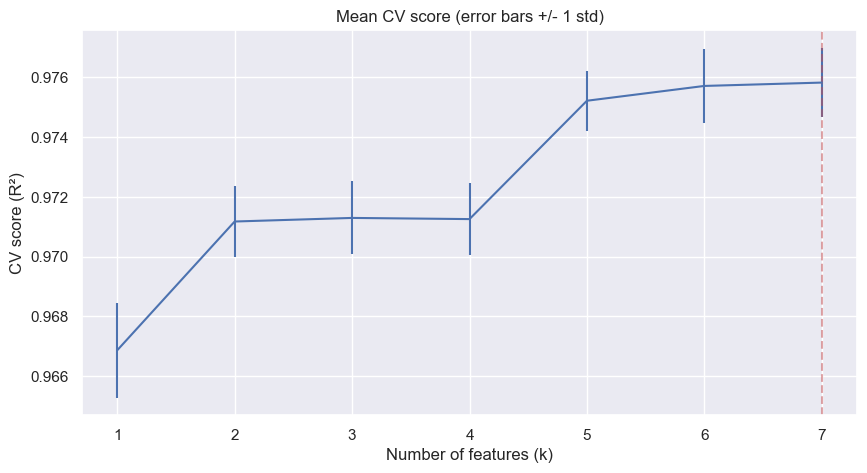

In [14]:
sns.set()
best_k = ln_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('Number of features (k)')
plt.ylabel('CV score (R²)')
plt.title('Mean CV score (error bars +/- 1 std)');

The results from the `GridSearchCV` indicate that even using a single feature yields a high `R² score` of `0.9669`, highlighting that certain features in the dataset are highly correlated with the target variable. As more features are added, the `R² scores` increase marginally, reaching the highest value of `0.9758` when all `7` features are included. This implies that while additional features provide a slight improvement in model performance, the initial few features already account for most of the variance in the data.

However, since the total number of features is only `7` and including all of them results in better predictions, there is no need to exclude any features to reduce training time. Therefore, we will proceed with all the features for further analysis.

Next, let's examine the importance of each feature in predicting the target variable.

In [15]:
coefficients = ln_grid_cv.best_estimator_.named_steps.linearregression.coef_
feature_names = X.columns

# Create a DataFrame to hold feature names and their coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients}).sort_values(by='Coefficient',ascending=False).reset_index(drop=True)


# Display the ranked features
coef_df

,Feature,Coefficient
0,Discharge Time (s),196.411678
1,Time at 4.15V (s),64.279425
2,Max. Voltage Dischar. (V),58.438209
3,Charging time (s),13.127958
4,Time constant current (s),9.605139
5,Min. Voltage Charg. (V),7.213227
6,Decrement 3.6-3.4V (s),-14.436953


The `linear regression model`'s coefficients reveal that `Discharge Time (s)` is the most significant predictor of the `target variable`, with a coefficient of `196.41`, indicating its strong influence on model performance. Following this, `Time at 4.15V (s)` and `Max. Voltage Discharge (V)` also play key roles, with coefficients of `64.28` and `58.44`, respectively. While features like `Decrement 3.6-3.4V (s)` and `Charging Time (s)` have a more moderate impact, they still contribute to the overall predictive power of the model. The least influential features are `Time Constant Current (s)` and `Min. Voltage Charge (V)`, though their effects are not negligible. Despite varying levels of importance, including all seven features provides the best predictive accuracy, as shown in the `GridSearchCV` results.

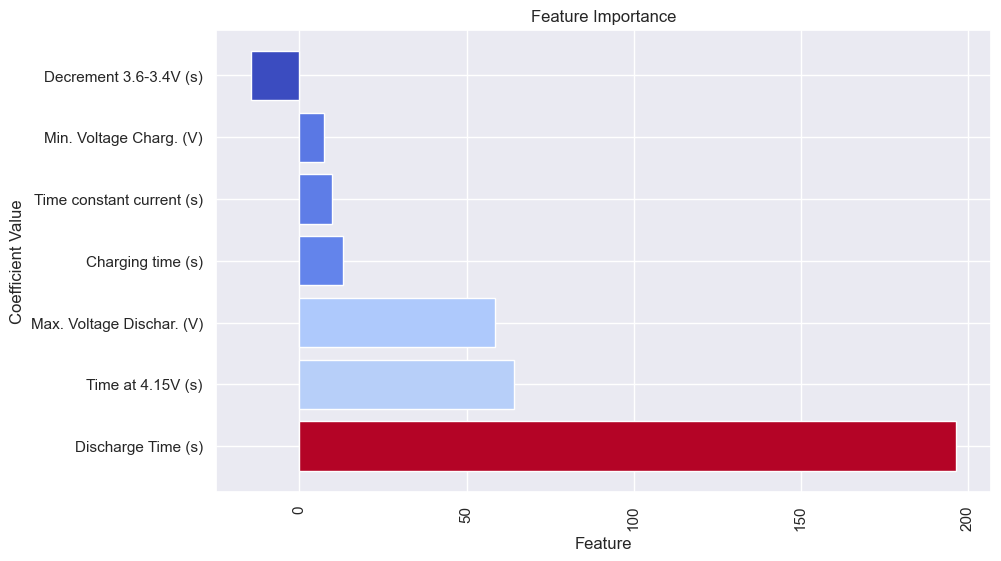

In [16]:
plt.figure(figsize=(10, 6))
norm = plt.Normalize(vmin=coef_df['Coefficient'].min(), vmax=coef_df['Coefficient'].max())
cmap = plt.get_cmap('coolwarm')

# Apply the colormap to the normalized coefficient values
colors = cmap(norm(coef_df['Coefficient']))
plt.title('Feature Importance')
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

## Model 2 : Lasso (L1 regularization)

Given that the features are strongly intercorrelated, using `Lasso` (`L1 regularization`) is an appropriate next step. `Lasso` can help mitigate `multicollinearity` by shrinking the less important feature coefficients to `zero`, effectively selecting a subset of features. This approach not only helps identify the most relevant features but also simplifies the model, potentially enhancing generalization.

In [17]:
grid_params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
}
lasso_Reg = Lasso(random_state=123)

lasso_grid_cv = GridSearchCV(lasso_Reg, param_grid=grid_params, cv=5, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)

print(f'best_params: {lasso_grid_cv.best_params_}')

best_params: {'alpha': 0.01}


In [18]:
results_df = pd.DataFrame({
    'Alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
    'R² Score': lasso_grid_cv.cv_results_['mean_test_score'],
    'Standard Deviation': lasso_grid_cv.cv_results_['std_test_score']
})

# Display the table
results_df

,Alpha,R² Score,Standard Deviation
0,0.0001,0.975821,0.001168
1,0.0010,0.975821,0.001168
2,0.0100,0.975821,0.001165
3,0.1000,0.975814,0.001141
4,1.0000,0.975641,0.001115
5,10.0000,0.974535,0.000977


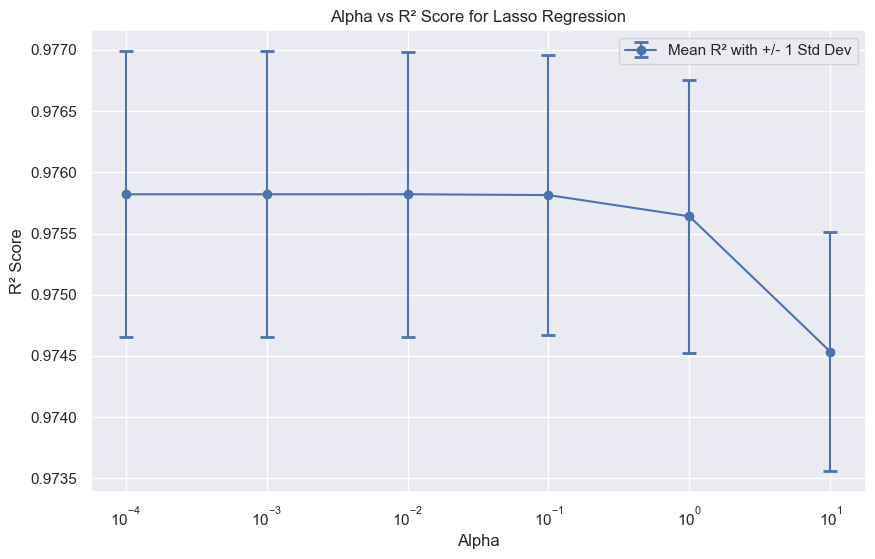

In [19]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["Alpha"], results_df["R² Score"], yerr=results_df["Standard Deviation"], fmt='-o', capsize=5, capthick=2, label='Mean R² with +/- 1 Std Dev')
plt.xscale('log')  # Logarithmic scale for alpha values
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Alpha vs R² Score for Lasso Regression')
plt.legend()
plt.show()

The results from applying `Lasso regression` with various regularization parameters (`alpha`) indicate that the model's `R² score` remains relatively high across different values of `alpha`. Here's a breakdown:

* For small values of `alpha` (`0.0001` to `0.01`), the `R² score` is around `0.9758`, showing minimal impact on the model's performance. This suggests that even with minimal regularization, the model captures most of the variance in the `target variable`.
* As `alpha` increases (`0.1` to `10`), the `R² score` slightly decreases, indicating that the model is starting to regularize and shrink some coefficients. However, the `R² scores` still remain high, suggesting that the most important features are retained despite some coefficients being reduced.
* The standard deviation decreases as alpha increases, reflecting a more stable model with reduced variance.
  
Overall, the `Lasso regression` results indicate that the features are strong predictors of the target variable, and even with regularization, the model maintains high predictive performance. The slight drop in `R²` at higher `alpha` values suggests that regularization is beginning to limit the influence of less important.

In [20]:
lasso_Reg = Lasso(alpha=0.01, random_state=123)
lasso_Reg.fit(X_train, y_train)
y_tr_pred = lasso_Reg.predict(X_train)
y_te_pred = lasso_Reg.predict(X_test)

In [21]:
lasso_Metrics_Table = pd.DataFrame({"Metrics": ["R²","MAE","RMSE"],
 "Train":[r2_score(y_train, y_tr_pred),
          root_mean_squared_error(y_train, y_tr_pred),
          mean_absolute_error(y_train, y_tr_pred)],
 "Test":[r2_score(y_test, y_te_pred),
        root_mean_squared_error(y_test, y_te_pred),
        mean_absolute_error(y_test, y_te_pred)]
})
lasso_Metrics_Table.set_index("Metrics")

,Train,Test
Metrics,,
R²,0.976022,0.976884
MAE,49.483648,48.748702
RMSE,37.026780,36.692422


The near-identical results confirm that the linear model and the Lasso model with a very small alpha are functionally equivalent in this case, emphasizing the robustness of the features used in the prediction.

## Model3 : Gradient Boosting Regressor

In [22]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 12, 15]
}

gb_Reg = GradientBoostingRegressor(random_state = 123)

# Set up GridSearchCV
gb_grid_cv = GridSearchCV(gb_Reg, param_grid=param_grid, cv=5, n_jobs=-1)
gb_grid_cv.fit(X_train, y_train)

print("Best Parameters:", gb_grid_cv.best_params_)

Best Parameters: {'max_depth': 10}


In [23]:
results_df = pd.DataFrame({
    'max_depth': [3, 5, 7, 10, 12, 15],
    'R² Score': gb_grid_cv.cv_results_['mean_test_score'],
    'Standard Deviation': gb_grid_cv.cv_results_['std_test_score']
})

# Display the table
results_df

,max_depth,R² Score,Standard Deviation
0,3,0.984798,0.000624
1,5,0.991445,0.000462
2,7,0.994892,0.000306
3,10,0.996181,0.000287
4,12,0.995634,0.000360
5,15,0.993978,0.000687


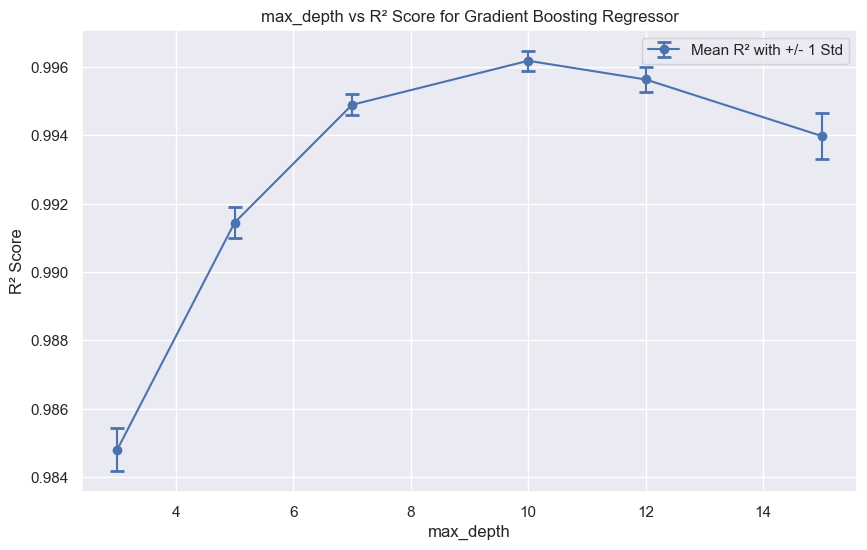

In [24]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["max_depth"], results_df["R² Score"], yerr=results_df["Standard Deviation"], fmt='-o', capsize=5, capthick=2, label='Mean R² with +/- 1 Std') 
plt.xlabel('max_depth')
plt.ylabel('R² Score')
plt.title('max_depth vs R² Score for Gradient Boosting Regressor')
plt.legend()
plt.show()

The model with `max_depth = 10` achieved the highest `R² score` of `0.9962`, indicating the best fit on the test data with the lowest variability (`standard deviation`) among the tested values.
As `max_depth` increases from `3` to `10`, the `R² score` consistently improves, reflecting better model performance. However, beyond `max_depth = 10`, the `R² score` slightly decreases, with `max_depth = 15` showing a higher standard deviation, which suggests potential overfitting.

In [25]:
param_grid = {
'learning_rate': [0.03, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15]
}

gb_Reg = GradientBoostingRegressor(random_state = 123, max_depth = 10)

# Set up GridSearchCV
gb_grid_cv = GridSearchCV(gb_Reg, param_grid=param_grid, cv=5, n_jobs=-1)
gb_grid_cv.fit(X_train, y_train)

print("Best Parameters:", gb_grid_cv.best_params_)

Best Parameters: {'learning_rate': 0.1}


In [26]:
results_df = pd.DataFrame({
    'learning_rate': [0.03, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15],
    'R² Score': gb_grid_cv.cv_results_['mean_test_score'],
    'Standard Deviation': gb_grid_cv.cv_results_['std_test_score']
})

# Display the table
results_df

,learning_rate,R² Score,Standard Deviation
0,0.03,0.993425,0.000279
1,0.05,0.995994,0.000251
2,0.07,0.996066,0.000240
3,0.08,0.996139,0.000307
4,0.09,0.996102,0.000289
5,0.10,0.996181,0.000287
6,0.11,0.996152,0.000244
7,0.12,0.996140,0.000302
8,0.15,0.996156,0.000366


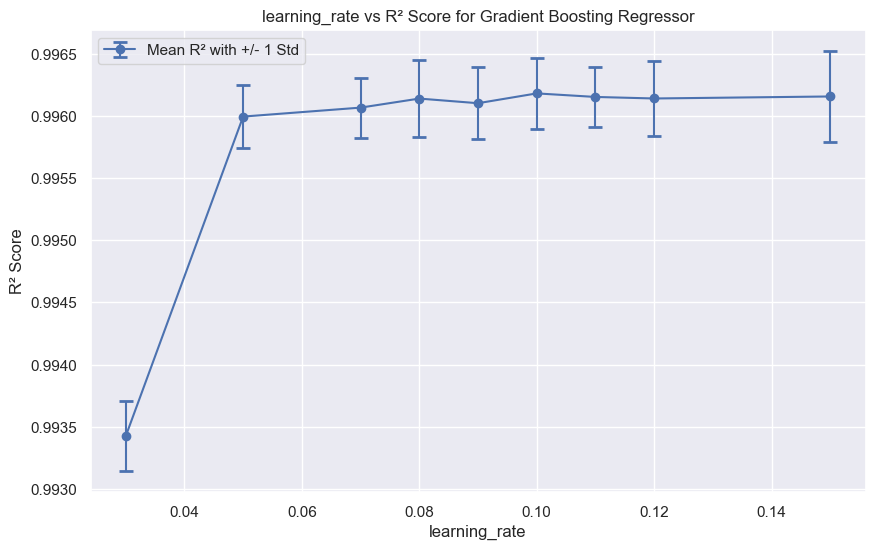

In [27]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["learning_rate"], results_df["R² Score"], yerr=results_df["Standard Deviation"], fmt='-o', capsize=5, capthick=2, label='Mean R² with +/- 1 Std') 
plt.xlabel('learning_rate')
plt.ylabel('R² Score')
plt.title('learning_rate vs R² Score for Gradient Boosting Regressor')
plt.legend()
plt.show()

The model with a `learning_rate` of `0.10` achieved the highest `R² score` of `0.996181`, showing the best performance on the test data with a relatively low standard deviation.
Increasing the learning_rate from `0.03` to `0.10` generally improves the `R² score`. However, after `0.10`, the scores are quite stable, and the differences are minimal. The standard deviations remain small and consistent, indicating stable performance across different values.

In [28]:
param_grid = {
    'n_estimators': [50, 100, 150, 300, 1000]
}

gb_Reg = GradientBoostingRegressor(random_state = 123,max_depth = 10, learning_rate=0.10)

# Set up GridSearchCV
gb_grid_cv = GridSearchCV(gb_Reg, param_grid=param_grid, cv=5, n_jobs=-1)
gb_grid_cv.fit(X_train, y_train)

print("Best Parameters:", gb_grid_cv.best_params_)

Best Parameters: {'n_estimators': 1000}


In [29]:
results_df = pd.DataFrame({
    'n_estimators': [50, 100, 150, 300, 1000],
    'R² Score': gb_grid_cv.cv_results_['mean_test_score'],
    'Standard Deviation': gb_grid_cv.cv_results_['std_test_score']
})

# Display the table
results_df

,n_estimators,R² Score,Standard Deviation
0,50,0.995935,0.000269
1,100,0.996181,0.000287
2,150,0.996245,0.000289
3,300,0.996302,0.000289
4,1000,0.996329,0.000289


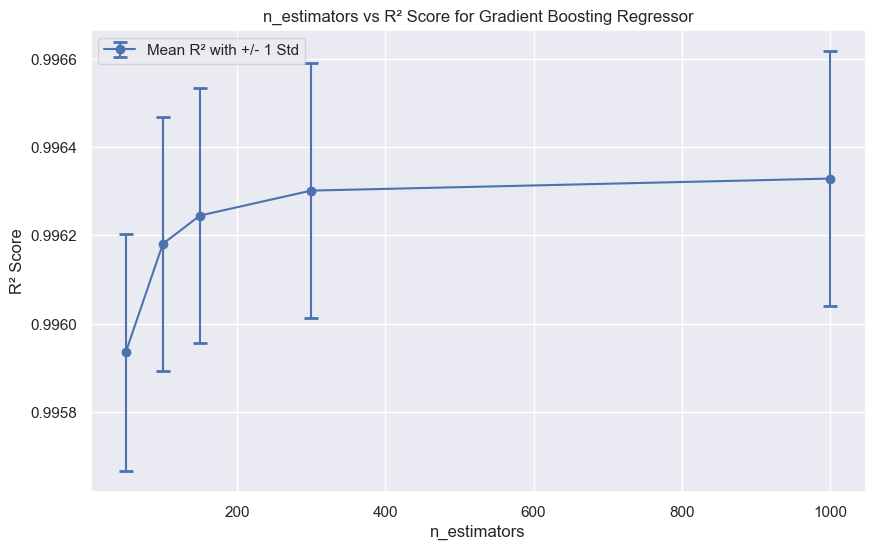

In [30]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["n_estimators"], results_df["R² Score"], yerr=results_df["Standard Deviation"], fmt='-o', capsize=5, capthick=2, label='Mean R² with +/- 1 Std') 
plt.xlabel('n_estimators')
plt.ylabel('R² Score')
plt.title('n_estimators vs R² Score for Gradient Boosting Regressor')
plt.legend()
plt.show()

The model with `n_estimators = 1000` achieves the highest `R² score` of `0.996329`, indicating the best performance with a very low `standard deviation`.
As the number of estimators increases, the `R² score` improves gradually. This trend suggests that more estimators enhance the model's ability to fit the data, leading to better performance.
While the `R² score` continues to improve with more estimators, the increases become marginal beyond `300 estimators`. The `standard deviation` remains quite stable across all values.


I conducted `GridSearchCV` for each parameter of the `GradientBoostingRegressor`—`max_depth`, `learning_rate`, and `n_estimators`—separately due to the extensive computation time required for evaluating all parameter combinations in a single grid search. This approach allowed for a more manageable optimization process, ensuring a thorough evaluation of each parameter's effect on model performance.

In [31]:
gb_Reg = GradientBoostingRegressor(n_estimators=300, learning_rate=0.10, max_depth=10, random_state=123)

# Train the model
gb_Reg.fit(X_train, y_train)

y_tr_pred = gb_Reg.predict(X_train)
y_te_pred = gb_Reg.predict(X_test)


GBR_Metrics_Table = pd.DataFrame({"Metrics": ["R²","MAE","RMSE"],
 "Train":[r2_score(y_train, y_tr_pred),
          root_mean_squared_error(y_train, y_tr_pred),
          mean_absolute_error(y_train, y_tr_pred)],
 "Test":[r2_score(y_test, y_te_pred),
        root_mean_squared_error(y_test, y_te_pred),
        mean_absolute_error(y_test, y_te_pred)]
})
GBR_Metrics_Table

,Metrics,Train,Test
0,R²,0.999985,0.997332
1,MAE,1.224533,16.561884
2,RMSE,0.898504,8.434242


The model achieves an almost perfect `R² score` on the `training set` (`0.999985`) and a very high score on the `test set` (`0.997332`), indicating excellent predictive performance.
The `training MAE` is very low (`1.224533`), while the `test MAE` is higher (`16.561884`), which may suggest some `overfitting`.
Similarly, the `training RMSE` is very low (`0.898504`), and the `test RMSE` is higher (`8.434242`), also indicating potential `overfitting`.

The results suggest that while the model performs exceptionally well on the training data, there is a noticeable drop in performance on the test data, which could be due to overfitting.

In [32]:
# Feature importance
importances = gb_Reg.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the ranked features
importance_df

,Feature,Importance
2,Discharge Time (s),0.870830
1,Time constant current (s),0.076501
3,Decrement 3.6-3.4V (s),0.026432
0,Time at 4.15V (s),0.009111
4,Max. Voltage Dischar. (V),0.008645
5,Charging time (s),0.005023
6,Min. Voltage Charg. (V),0.003457


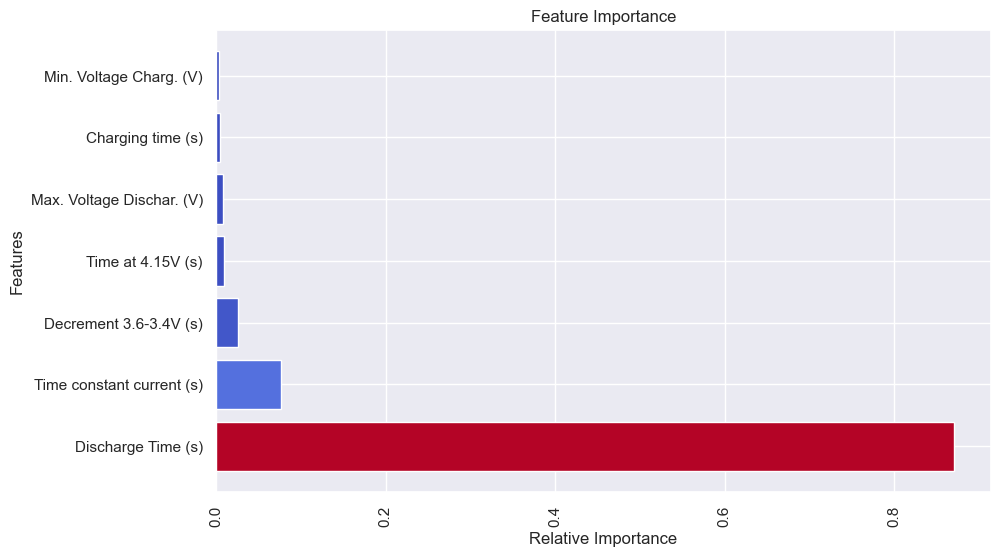

In [34]:
norm = plt.Normalize(vmin=importance_df['Importance'].min(), vmax=importance_df['Importance'].max())
cmap = plt.get_cmap('coolwarm')

# Apply the colormap to the normalized importance values
colors = cmap(norm(importance_df['Importance']))

# Create the bar plot with vertical bars
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.ylabel('Features')
plt.show()

* Most Important Feature: `Discharge Time (s)` has the highest `importance score` (`0.869010`), indicating it is the most significant feature for predicting the `target variable`.
* Least Important Features: `Min. Voltage Charg. (V)` has the lowest `importance score` (`0.003388`), making it the least influential feature in the model.

## Model4 : Random Forest Regressor

In [35]:
param_grid = {'n_estimators': [10, 50, 100, 200,300,400]
}

rf_Reg = RandomForestRegressor(random_state=123)
# Set up GridSearchCV
rf_grid_cv = GridSearchCV(rf_Reg, param_grid=param_grid, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

print("Best Parameters:", rf_grid_cv.best_params_)

Best Parameters: {'n_estimators': 400}


In [36]:
results_df = pd.DataFrame({
    'n_estimators': [10, 50, 100, 200,300,400],
    'R² Score': rf_grid_cv.cv_results_['mean_test_score'],
    'Standard Deviation': rf_grid_cv.cv_results_['std_test_score']
})

# Display the table
results_df

,n_estimators,R² Score,Standard Deviation
0,10,0.995517,0.000274
1,50,0.996171,0.000371
2,100,0.996261,0.000313
3,200,0.996305,0.000325
4,300,0.996317,0.000326
5,400,0.996326,0.000327


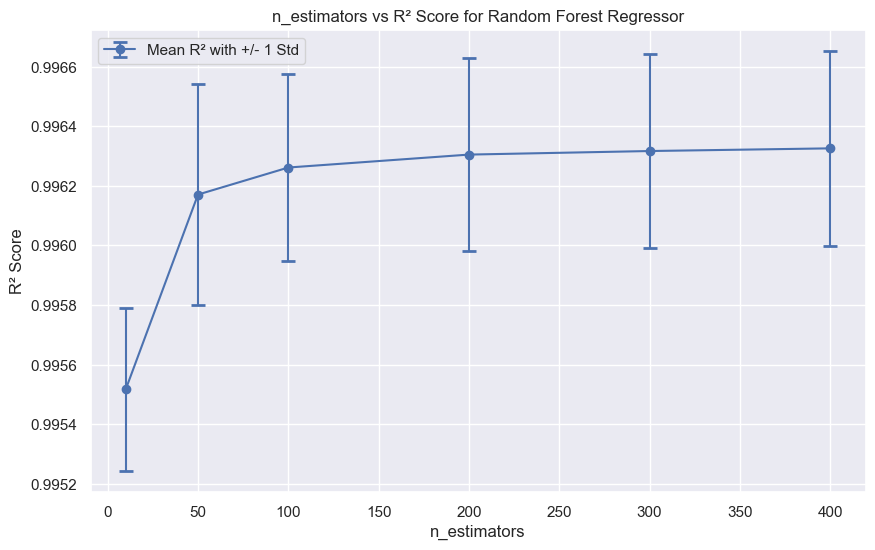

In [37]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["n_estimators"], results_df["R² Score"], yerr=results_df["Standard Deviation"], fmt='-o', capsize=5, capthick=2, label='Mean R² with +/- 1 Std') 
plt.xlabel('n_estimators')
plt.ylabel('R² Score')
plt.title('n_estimators vs R² Score for Random Forest Regressor')
plt.grid(True)
plt.legend()
plt.show()

The optimal value for `n_estimators` is `400`, achieving the highest `R² score` of `0.996326` with a very small `standard deviation` (`0.000327`), indicating excellent and stable performance.
As the number of estimators increases from `10` to `400`, the `R² score` improves, suggesting that more estimators generally enhance model performance. The improvements become marginal beyond `200 estimators`.

In [38]:
param_grid = {'max_depth': [15, 20, 25, 30, 35]
}

rf_Reg = RandomForestRegressor(random_state=123, n_estimators = 200)

rf_grid_cv = GridSearchCV(rf_Reg, param_grid=param_grid, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

print("Best Parameters:", rf_grid_cv.best_params_)

Best Parameters: {'max_depth': 20}


In [39]:
results_df = pd.DataFrame({
    'max_depth': [15, 20, 25, 30, 35],
    'R² Score': rf_grid_cv.cv_results_['mean_test_score'],
    'Standard Deviation': rf_grid_cv.cv_results_['std_test_score']
})

# Display the table
results_df

,max_depth,R² Score,Standard Deviation
0,15,0.996201,0.000333
1,20,0.996309,0.000324
2,25,0.996304,0.000318
3,30,0.996307,0.000324
4,35,0.996305,0.000325


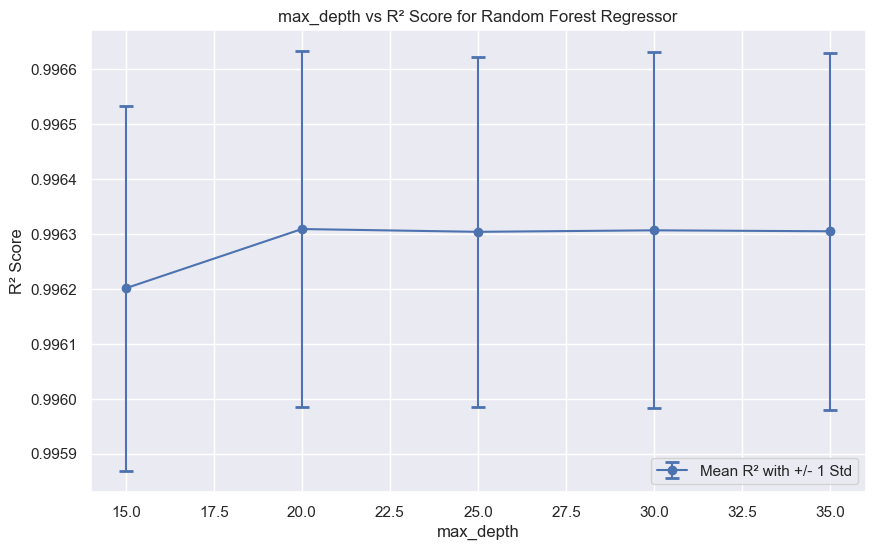

In [40]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["max_depth"], results_df["R² Score"], yerr=results_df["Standard Deviation"], fmt='-o', capsize=5, capthick=2, label='Mean R² with +/- 1 Std') 
plt.xlabel('max_depth')
plt.ylabel('R² Score')
plt.title('max_depth vs R² Score for Random Forest Regressor')
plt.legend()
plt.show()

The optimal value for `max_depth` is `20`, achieving the highest `R² score` of `0.996309` with a stable `standard deviation` (`0.000324`).
The `R² score` improves as `max_depth` increases from `15` to `20`, but beyond `20`, the `score` remains fairly stable with only slight changes.

**Conclusion:** \
For the `RandomForestRegressor` with `n_estimators = 200`, a `max_depth` of `20` provides the best performance, maximizing the `R² score` while maintaining stability in the model's performance.

In [41]:
rf_Reg = RandomForestRegressor(n_estimators=200, max_depth = 20, random_state=123)

# Train the model
rf_Reg.fit(X_train, y_train)

y_tr_pred = rf_Reg.predict(X_train)
y_te_pred = rf_Reg.predict(X_test)


RFR_Metrics_Table = pd.DataFrame({"Metrics": ["R²","MAE","RMSE"],
 "Train":[r2_score(y_train, y_tr_pred),
          root_mean_squared_error(y_train, y_tr_pred),
          mean_absolute_error(y_train, y_tr_pred)],
 "Test":[r2_score(y_test, y_te_pred),
        root_mean_squared_error(y_test, y_te_pred),
        mean_absolute_error(y_test, y_te_pred)]
})
RFR_Metrics_Table

,Metrics,Train,Test
0,R²,0.999542,0.997222
1,MAE,6.837620,16.900478
2,RMSE,3.419183,8.674764


The model performs exceptionally well with an `R² score` of `0.999542` on the `training data` and `0.997222` on the `test data`, indicating high accuracy in explaining the `variance`.
The `training MAE` is `6.837620`, and the `test MAE` is `16.900478`, suggesting some level of `overfitting`.
The `training RMSE` is `3.419183`, while the test `RMSE` is `8.674764`, further indicating potential `overfitting`.

The results are similar to those of the `GradientBoostingRegressor`, showing that both models perform very well but might be `overfitting` the `training data` to some extent.

In [42]:
coefficients = rf_Reg.feature_importances_
feature_names = X.columns

# Create a DataFrame to hold feature names and their coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Rank features by the absolute value of coefficients
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the ranked features
coef_df

,Feature,Coefficient,Absolute Coefficient
2,Discharge Time (s),0.876475,0.876475
1,Time constant current (s),0.064472,0.064472
3,Decrement 3.6-3.4V (s),0.037042,0.037042
4,Max. Voltage Dischar. (V),0.008448,0.008448
0,Time at 4.15V (s),0.005144,0.005144
5,Charging time (s),0.005109,0.005109
6,Min. Voltage Charg. (V),0.003310,0.003310


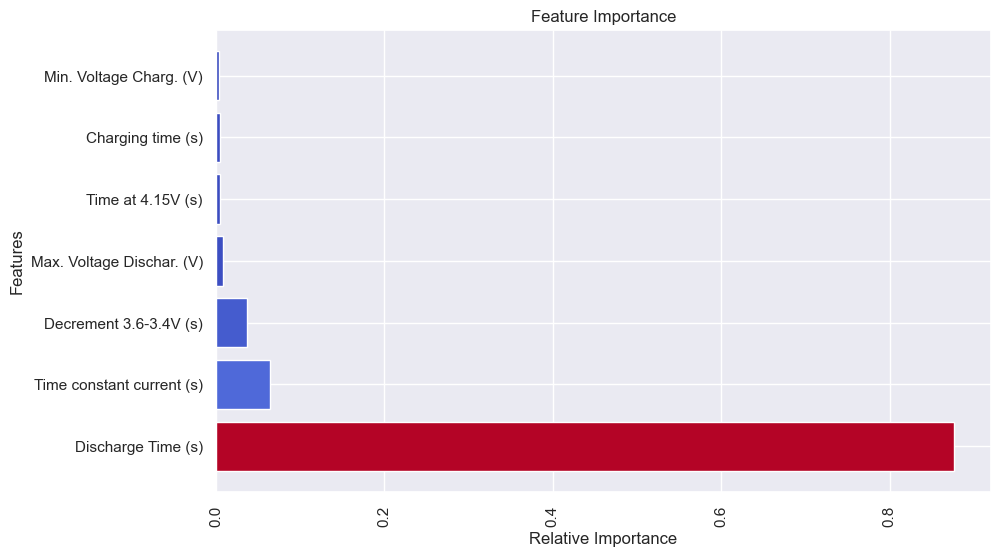

In [43]:
# Plot the ranked features
norm = plt.Normalize(vmin=coef_df['Coefficient'].min(), vmax=coef_df['Coefficient'].max())
cmap = plt.get_cmap('coolwarm')

# Apply the colormap to the normalized importance values
colors = cmap(norm(coef_df['Coefficient']))

# Create the bar plot with vertical bars
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.ylabel('Features')
plt.show()

* Most Important Feature: `Discharge Time (s)` has the highest `importance score` (`0.876475`), indicating it is the most significant feature in predicting the `target variable`.
* Least Important Features: `Min. Voltage Charg. (V)` has the lowest `importance score` (`0.003296`), making it the least influential feature in the model.

These results show that, similar to the `GradientBoostingRegressor`, the `Discharge Time (s)` feature plays a dominant role in the model’s predictions, while the other features contribute less to the model's performance.

# Conclusion: 
After evaluating various models, including `Linear Regression`, `Lasso Regression`, `GradientBoostingRegressor (GBR)`, and `RandomForestRegressor (RFR`), here are the findings:

* `Linear Model` and `Lasso Regression`: Both models performed well with high `R² scores`, indicating strong predictive capabilities. The `Lasso Regression`, with an `alpha` of `0.001`, showed nearly identical performance metrics to the `linear model`, suggesting that feature selection was not a significant factor.

* `GradientBoostingRegressor (GBR)`: This model demonstrated the highest `R² scores` and the lowest `MAE` and `RMSE` on the `training set`, though its performance on the `test set` was slightly better than `RFR`. However, `GBR` requires considerably more `computational time` to train.

* `RandomForestRegressor (RFR)`: This model provided very close performance metrics to `GBR`, with slightly higher `MAE` and `RMSE` but similar `R² scores`. `RFR` is more computationally efficient and trained faster than `GBR`.

**Recommendation:** Given the computational efficiency and similar performance, `RandomForestRegressor` is the preferred model. It balances `accuracy` and `training time` effectively, making it a practical choice for `large datasets` and scenarios where computational resources are a concern. If the dataset is not so big and have access to enough computational power GBR model is best.